In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from random import shuffle

In [2]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == '0' : return 0
    elif word_label == '1' : return 1
    elif word_label == '6' : return 2
    elif word_label == '12' : return 3
    elif word_label == '9' : return 4

In [3]:
def load_df(dir_name:str, size:int, grayscale:bool):
    data = []
    labels = []
    for img in os.listdir(dir_name):
        label = label_img(img)
        path = os.path.join(dir_name,img)
        if grayscale:
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(2*size,size))
        else:
            img = cv2.resize(cv2.imread(path),(2*size,size))
        data.append(np.array(np.array(img[0:size,0:size]).flatten()))
        labels.append(label)
    
    cols = []
    num = size*size
    if not grayscale:
        num *=3
    for i in range(num):
        cols.append("pixel_"+str(i))
    data = pd.DataFrame(data, columns=cols)
#     data = data/255
    data['label'] = labels
    data = data.sample(frac=1,random_state=0)
    return data


In [4]:
def train_test_split(data, samples_number :int, size:int, graysacle:bool):
    test = data.groupby('label').get_group(0).sample(n = samples_number)
    test = test.append(data.groupby('label').get_group(1).sample(n = samples_number))
    try:
        test = test.append(data.groupby('label').get_group(2).sample(n = samples_number))
    except:
        pass
    try:
        test = test.append(data.groupby('label').get_group(3).sample(n = samples_number))
    except:
        pass
    try:
        test = test.append(data.groupby('label').get_group(4).sample(n = samples_number))
    except:
        pass
    train = data[ ~data.index.isin(test.index) ]
    train_data = train.drop('label',axis=1)
    train_target = train['label']

    test_data = test.drop('label',axis=1)
    test_target = test['label']
    
    train_data_reshaped = []
    test_data_reshaped = []
    
    shape = (size,size)
    if not graysacle:
        shape = (size,size,3)
        
    for i in range(len(train_data)):
        t = train_data.iloc[i].values.reshape(shape)
        t = np.array(t)
        train_data_reshaped.append(t)

    for i in range(len(test_data)):
        t = test_data.iloc[i].values.reshape(shape)
        t = np.array(t)
        test_data_reshaped.append(t)
        
    train_data_reshaped = np.array(train_data_reshaped)
    test_data_reshaped = np.array(test_data_reshaped)
    
    if graysacle:
        test_data_reshaped = np.expand_dims(test_data_reshaped,axis=-1)
        train_data_reshaped = np.expand_dims(train_data_reshaped,axis=-1)
    
    return train_data_reshaped, train_target,test_data_reshaped,test_target

# Ptolemy I

In [72]:
dir_n = r'ptolemy I'
size = 70
is_gray = True
df = load_df(dir_n,size,is_gray)
class_num = 2
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

In [73]:
len(df)

2267

In [74]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4891,pixel_4892,pixel_4893,pixel_4894,pixel_4895,pixel_4896,pixel_4897,pixel_4898,pixel_4899,label
70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1171,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1246,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
971,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
361,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


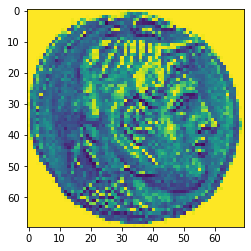

In [75]:
plt.imshow(x_train[0].reshape((size,size)))

In [91]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 68, 68, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 42)        12138     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 42)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 52)        19708     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 52)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 62)         

In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=15,batch_size = 18)

Epoch 1/15
101/101 [==============================] - 5s 46ms/step - loss: 0.5189 - accuracy: 0.7499
Epoch 2/15
101/101 [==============================] - 5s 52ms/step - loss: 0.0734 - accuracy: 0.9791
Epoch 3/15
101/101 [==============================] - 5s 49ms/step - loss: 0.0546 - accuracy: 0.9873
Epoch 4/15
101/101 [==============================] - 5s 49ms/step - loss: 0.0418 - accuracy: 0.9901
Epoch 5/15
101/101 [==============================] - 5s 50ms/step - loss: 0.0410 - accuracy: 0.9901
Epoch 6/15
101/101 [==============================] - 5s 48ms/step - loss: 0.0288 - accuracy: 0.9945
Epoch 7/15
101/101 [==============================] - 5s 46ms/step - loss: 0.0243 - accuracy: 0.9950
Epoch 8/15
101/101 [==============================] - 5s 46ms/step - loss: 0.0186 - accuracy: 0.9950
Epoch 9/15
101/101 [==============================] - 5s 46ms/step - loss: 0.0170 - accuracy: 0.9961
Epoch 10/15
101/101 [==============================] - 5s 47ms/step - loss: 0.0116 - accura

15/15 - 0s - loss: 0.0566 - accuracy: 0.9889
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       226
           1       1.00      0.98      0.99       226

    accuracy                           0.99       452
   macro avg       0.99      0.99      0.99       452
weighted avg       0.99      0.99      0.99       452



Text(33.0, 0.5, 'Actual')

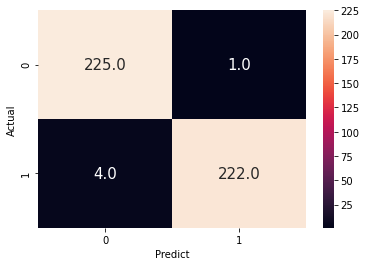

In [93]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# Ptolemy I VI XII

In [122]:
dir_n = r'mixed'
size = 150
is_gray = True
df = load_df(dir_n,size,is_gray)
class_num = 4
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

In [123]:
len(df)

3665

In [126]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 72, 72, 42)        12138     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 36, 36, 42)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 34, 34, 52)        19708     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 17, 17, 52)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 15, 15, 62)      

In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=29,batch_size = 29)

Epoch 1/29
102/102 [==============================] - 33s 325ms/step - loss: 1.0161 - accuracy: 0.5554
Epoch 2/29
102/102 [==============================] - 35s 346ms/step - loss: 0.4100 - accuracy: 0.8507
Epoch 3/29
102/102 [==============================] - 34s 335ms/step - loss: 0.3061 - accuracy: 0.8902
Epoch 4/29
102/102 [==============================] - 34s 334ms/step - loss: 0.2148 - accuracy: 0.9304
Epoch 5/29
102/102 [==============================] - 34s 334ms/step - loss: 0.1737 - accuracy: 0.9417
Epoch 6/29
102/102 [==============================] - 34s 336ms/step - loss: 0.1440 - accuracy: 0.9567
Epoch 7/29
102/102 [==============================] - 34s 338ms/step - loss: 0.0899 - accuracy: 0.9707
Epoch 8/29
102/102 [==============================] - 35s 339ms/step - loss: 0.0605 - accuracy: 0.9795
Epoch 9/29
102/102 [==============================] - 36s 353ms/step - loss: 0.0833 - accuracy: 0.9707
Epoch 10/29
102/102 [==============================] - 38s 368ms/step - l

23/23 - 2s - loss: 0.5777 - accuracy: 0.9290
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       183
           1       0.95      0.96      0.95       183
           2       0.91      0.87      0.89       183
           3       0.90      0.90      0.90       183

    accuracy                           0.93       732
   macro avg       0.93      0.93      0.93       732
weighted avg       0.93      0.93      0.93       732



Text(33.0, 0.5, 'Actual')

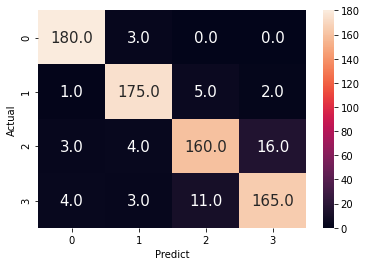

In [128]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# Ptolemy I VI XII and 9

In [5]:
dir_n = r'mixed'
size = 70
is_gray = True
df = load_df(dir_n,size,is_gray)
class_num = 5
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

C:\Users\Liorka\AppData\Local\Temp\ipykernel_5852\1003655868.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(1).sample(n = samples_number))
C:\Users\Liorka\AppData\Local\Temp\ipykernel_5852\1003655868.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(2).sample(n = samples_number))
C:\Users\Liorka\AppData\Local\Temp\ipykernel_5852\1003655868.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(3).sample(n = samples_number))
C:\Users\Liorka\AppData\Local\Temp\ipykernel_5852\1003655868.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pa

In [6]:
int(np.floor(len(df)*0.2)//class_num)

167

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 42)        12138     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 42)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 52)        19708     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 52)         0

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=29,batch_size = 29)

Epoch 1/29
116/116 [==============================] - 3s 21ms/step - loss: 1.5165 - accuracy: 0.3902
Epoch 2/29
116/116 [==============================] - 3s 22ms/step - loss: 1.0157 - accuracy: 0.5701
Epoch 3/29
116/116 [==============================] - 2s 21ms/step - loss: 0.7223 - accuracy: 0.7162
Epoch 4/29
116/116 [==============================] - 2s 20ms/step - loss: 0.5827 - accuracy: 0.7813
Epoch 5/29
116/116 [==============================] - 2s 21ms/step - loss: 0.4958 - accuracy: 0.8091
Epoch 6/29
116/116 [==============================] - 3s 25ms/step - loss: 0.4450 - accuracy: 0.8360
Epoch 7/29
116/116 [==============================] - 2s 21ms/step - loss: 0.3747 - accuracy: 0.8599
Epoch 8/29
116/116 [==============================] - 2s 21ms/step - loss: 0.3372 - accuracy: 0.8739
Epoch 9/29
116/116 [==============================] - 2s 21ms/step - loss: 0.3065 - accuracy: 0.8903
Epoch 10/29
116/116 [==============================] - 2s 21ms/step - loss: 0.2889 - accura

27/27 - 0s - loss: 0.9340 - accuracy: 0.7988 - 411ms/epoch - 15ms/step
27/27 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       167
           1       0.92      0.91      0.91       167
           2       0.78      0.79      0.78       167
           3       0.68      0.69      0.68       167
           4       0.67      0.63      0.65       167

    accuracy                           0.80       835
   macro avg       0.80      0.80      0.80       835
weighted avg       0.80      0.80      0.80       835



Text(50.722222222222214, 0.5, 'Actual')

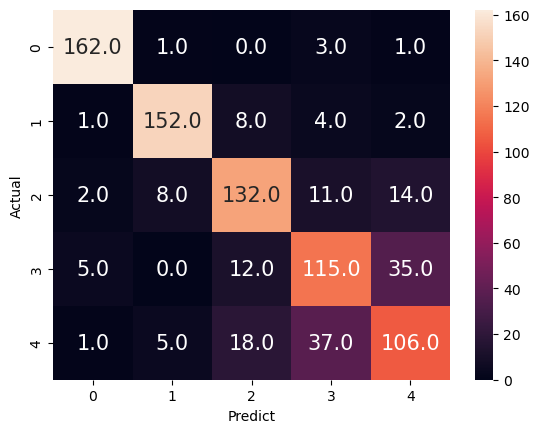

In [9]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

## VGG16

In [5]:
dir_n = r'mixed'
size = 150
is_gray = False
df = load_df(dir_n,size,is_gray)
class_num = 5
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

C:\Users\Liorka\AppData\Local\Temp\ipykernel_22536\1003655868.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(1).sample(n = samples_number))
C:\Users\Liorka\AppData\Local\Temp\ipykernel_22536\1003655868.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(2).sample(n = samples_number))
C:\Users\Liorka\AppData\Local\Temp\ipykernel_22536\1003655868.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(3).sample(n = samples_number))
C:\Users\Liorka\AppData\Local\Temp\ipykernel_22536\1003655868.py:13: FutureWarning: The frame.append method is deprecated and will be removed fro

<Axes: xlabel='label', ylabel='count'>

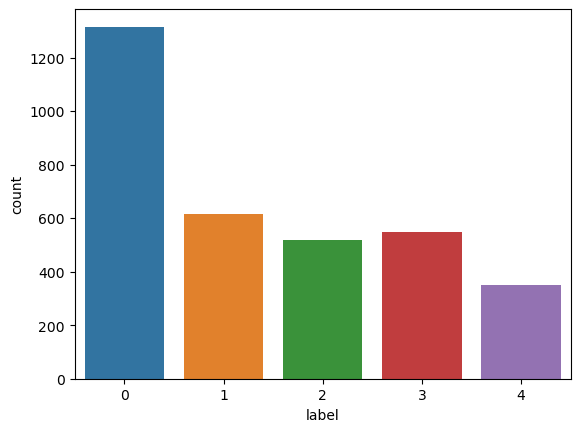

In [6]:
sns.countplot(x = y_train)

<Axes: xlabel='label', ylabel='count'>

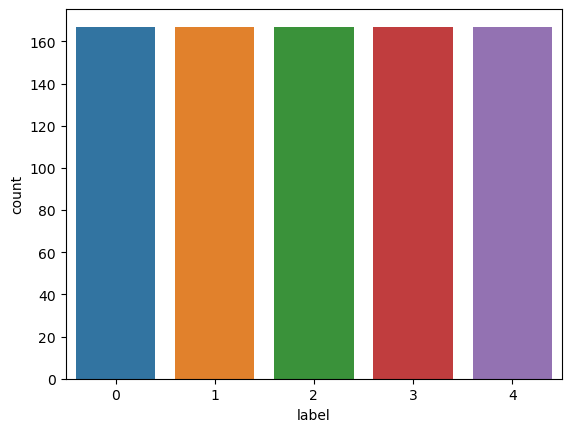

In [7]:
sns.countplot(x = y_test)

In [109]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
## Preprocessing input do not scale the if you want to use this preprocess!!!!!!!!!
x_train_pre = preprocess_input(x_train) 
x_test_pre = preprocess_input(x_test)

In [110]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [111]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
],name = "Simple_VGG16")
model.summary()

Model: "Simple_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_21 (Flatten)        (None, 8192)              0         
                                                                 
 dense_63 (Dense)            (None, 64)                524352    
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 dense_65 (Dense)            (None, 5)                 165       
                                                                 
Total params: 15,241,285
Trainable params: 526,597
Non-trainable params: 14,714,688
_________________________________________________________________


In [112]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 113s 1s/step - loss: 3.5771 - accuracy: 0.7218 - val_loss: 0.8986 - val_accuracy: 0.7401
Epoch 2/33
102/102 [==============================] - 116s 1s/step - loss: 0.9375 - accuracy: 0.8763 - val_loss: 0.8631 - val_accuracy: 0.7880
Epoch 3/33
102/102 [==============================] - 116s 1s/step - loss: 0.6038 - accuracy: 0.9190 - val_loss: 0.9491 - val_accuracy: 0.7880
Epoch 4/33
102/102 [==============================] - 117s 1s/step - loss: 0.5211 - accuracy: 0.9289 - val_loss: 0.7413 - val_accuracy: 0.8036
Epoch 5/33
102/102 [==============================] - 116s 1s/step - loss: 0.3095 - accuracy: 0.9624 - val_loss: 1.0049 - val_accuracy: 0.8036
Epoch 6/33
102/102 [==============================] - 117s 1s/step - loss: 0.2268 - accuracy: 0.9713 - val_loss: 0.8582 - val_accuracy: 0.7952
Epoch 7/33
102/102 [==============================] - 118s 1s/step - loss: 0.1287 - accuracy: 0.9863 - val_loss: 0.8503 - val_accuracy: 0.8204

27/27 - 23s - loss: 1.0118 - accuracy: 0.8228 - 23s/epoch - 843ms/step
27/27 [==============================] - 23s 835ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       167
           1       0.93      0.93      0.93       167
           2       0.86      0.81      0.83       167
           3       0.68      0.72      0.70       167
           4       0.69      0.69      0.69       167

    accuracy                           0.82       835
   macro avg       0.83      0.82      0.82       835
weighted avg       0.83      0.82      0.82       835



Text(50.722222222222214, 0.5, 'Actual')

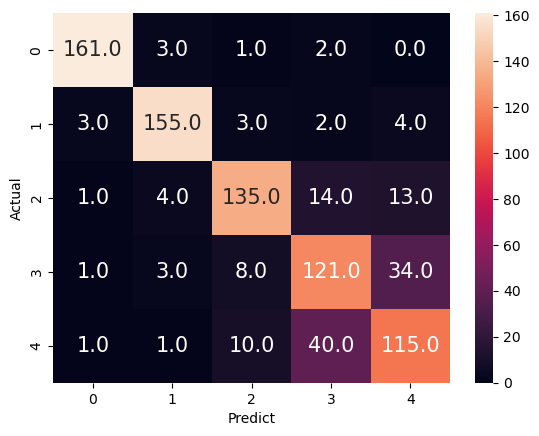

In [113]:
test_loss, test_acc = model.evaluate(x_test_pre,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# VGG16 with dropout layers

In [115]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers:
    layer.trainable = False

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
drop_1 = layers.Dropout(0.3)
dense_layer_2 = layers.Dense(256, activation='relu')
drop_2 = layers.Dropout(0.2)
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_1,
    dense_layer_2,
    drop_2,
    prediction_layer
],name = "VGG16_with_dropout_layers")
model.summary()

Model: "VGG16_with_dropout_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_22 (Flatten)        (None, 8192)              0         
                                                                 
 dense_66 (Dense)            (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_67 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_68 (Dense)            (None, 5)   

In [116]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 119s 1s/step - loss: 11.8518 - accuracy: 0.6391 - val_loss: 1.0372 - val_accuracy: 0.7389
Epoch 2/33
102/102 [==============================] - 117s 1s/step - loss: 2.2730 - accuracy: 0.7795 - val_loss: 0.8428 - val_accuracy: 0.7772
Epoch 3/33
102/102 [==============================] - 117s 1s/step - loss: 1.6631 - accuracy: 0.8174 - val_loss: 0.8512 - val_accuracy: 0.7701
Epoch 4/33
102/102 [==============================] - 116s 1s/step - loss: 1.2684 - accuracy: 0.8473 - val_loss: 0.6727 - val_accuracy: 0.8036
Epoch 5/33
102/102 [==============================] - 117s 1s/step - loss: 1.1416 - accuracy: 0.8551 - val_loss: 0.7445 - val_accuracy: 0.7820
Epoch 6/33
102/102 [==============================] - 119s 1s/step - loss: 1.0918 - accuracy: 0.8661 - val_loss: 0.6183 - val_accuracy: 0.8144
Epoch 7/33
102/102 [==============================] - 116s 1s/step - loss: 0.9098 - accuracy: 0.8835 - val_loss: 0.8065 - val_accuracy: 0.785

27/27 - 23s - loss: 1.0684 - accuracy: 0.8287 - 23s/epoch - 839ms/step
27/27 [==============================] - 23s 837ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       167
           1       0.91      0.95      0.93       167
           2       0.87      0.74      0.80       167
           3       0.70      0.78      0.74       167
           4       0.71      0.68      0.70       167

    accuracy                           0.83       835
   macro avg       0.83      0.83      0.83       835
weighted avg       0.83      0.83      0.83       835



Text(50.722222222222214, 0.5, 'Actual')

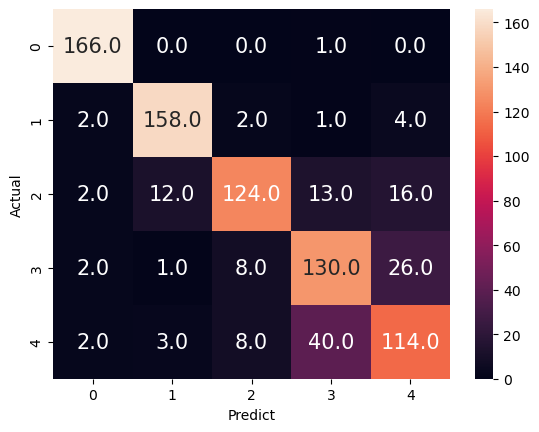

In [117]:
test_loss, test_acc = model.evaluate(x_test_pre,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# VGG16 with extra conv layers

In [102]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers:
    layer.trainable = False

conv_layer_1 = layers.Conv2D(62, (2, 2), activation='relu')
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,
    conv_layer_1,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "VGG16_with_extra_conv_layers")
model.summary()

Model: "VGG16_with_extra_conv_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_41 (Conv2D)          (None, 3, 3, 62)          127038    
                                                                 
 flatten_19 (Flatten)        (None, 558)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                35776     
                                                                 
 dense_58 (Dense)            (None, 32)                2080      
                                                                 
 dense_59 (Dense)            (None, 5)                 165       
                                                                 
Total params: 14,879,747
Trainable par

In [103]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 113s 1s/step - loss: 3.1891 - accuracy: 0.6848 - val_loss: 0.7849 - val_accuracy: 0.7461
Epoch 2/33
102/102 [==============================] - 114s 1s/step - loss: 0.9278 - accuracy: 0.8682 - val_loss: 0.8234 - val_accuracy: 0.7449
Epoch 3/33
102/102 [==============================] - 116s 1s/step - loss: 0.6114 - accuracy: 0.9199 - val_loss: 0.6960 - val_accuracy: 0.7737
Epoch 4/33
102/102 [==============================] - 116s 1s/step - loss: 0.3875 - accuracy: 0.9462 - val_loss: 0.7726 - val_accuracy: 0.7749
Epoch 5/33
102/102 [==============================] - 116s 1s/step - loss: 0.3234 - accuracy: 0.9585 - val_loss: 0.7149 - val_accuracy: 0.7964
Epoch 6/33
102/102 [==============================] - 116s 1s/step - loss: 0.2202 - accuracy: 0.9743 - val_loss: 0.7112 - val_accuracy: 0.7952
Epoch 7/33
102/102 [==============================] - 116s 1s/step - loss: 0.2012 - accuracy: 0.9761 - val_loss: 0.7857 - val_accuracy: 0.8048

27/27 - 23s - loss: 0.8219 - accuracy: 0.8251 - 23s/epoch - 835ms/step
27/27 [==============================] - 23s 828ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       167
           1       0.90      0.95      0.92       167
           2       0.84      0.75      0.79       167
           3       0.74      0.69      0.71       167
           4       0.68      0.78      0.73       167

    accuracy                           0.83       835
   macro avg       0.83      0.83      0.83       835
weighted avg       0.83      0.83      0.83       835



Text(50.722222222222214, 0.5, 'Actual')

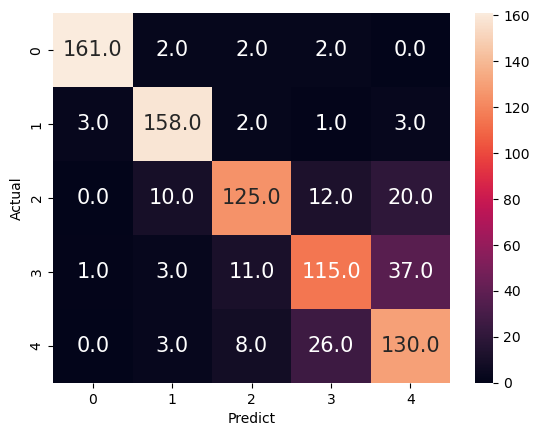

In [104]:
test_loss, test_acc = model.evaluate(x_test_pre,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# VGG19

In [118]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
## Preprocessing input do not scale the if you want to use this preprocess!!!!!!!!!
x_train_pre = preprocess_input(x_train) 
x_test_pre = preprocess_input(x_test)

In [119]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [120]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "Simple_VGG19")
model.summary()

Model: "Simple_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_23 (Flatten)        (None, 8192)              0         
                                                                 
 dense_69 (Dense)            (None, 64)                524352    
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dense_71 (Dense)            (None, 5)                 165       
                                                                 
Total params: 20,550,981
Trainable params: 526,597
Non-trainable params: 20,024,384
_________________________________________________________________


In [121]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 148s 1s/step - loss: 2.8096 - accuracy: 0.7171 - val_loss: 0.7648 - val_accuracy: 0.7413
Epoch 2/33
102/102 [==============================] - 144s 1s/step - loss: 0.9842 - accuracy: 0.8706 - val_loss: 0.6375 - val_accuracy: 0.8108
Epoch 3/33
102/102 [==============================] - 144s 1s/step - loss: 0.6168 - accuracy: 0.9190 - val_loss: 0.6803 - val_accuracy: 0.8000
Epoch 4/33
102/102 [==============================] - 145s 1s/step - loss: 0.4302 - accuracy: 0.9420 - val_loss: 0.6718 - val_accuracy: 0.8168
Epoch 5/33
102/102 [==============================] - 145s 1s/step - loss: 0.3412 - accuracy: 0.9558 - val_loss: 0.6753 - val_accuracy: 0.8216
Epoch 6/33
102/102 [==============================] - 145s 1s/step - loss: 0.3121 - accuracy: 0.9609 - val_loss: 0.8265 - val_accuracy: 0.8036
Epoch 7/33
102/102 [==============================] - 146s 1s/step - loss: 0.2153 - accuracy: 0.9707 - val_loss: 0.8134 - val_accuracy: 0.7940

27/27 - 30s - loss: 0.9361 - accuracy: 0.8311 - 30s/epoch - 1s/step
27/27 [==============================] - 29s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       167
           1       0.85      0.96      0.90       167
           2       0.82      0.80      0.81       167
           3       0.71      0.77      0.74       167
           4       0.80      0.66      0.72       167

    accuracy                           0.83       835
   macro avg       0.83      0.83      0.83       835
weighted avg       0.83      0.83      0.83       835



Text(50.722222222222214, 0.5, 'Actual')

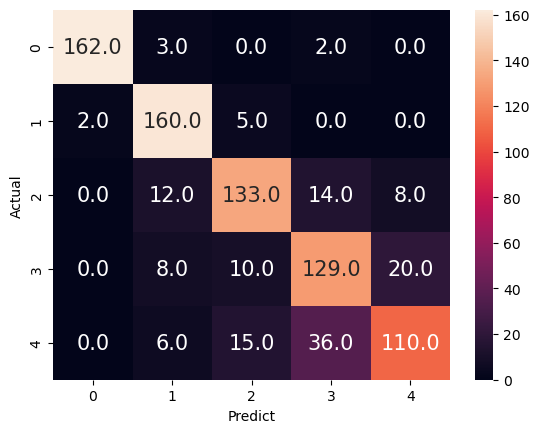

In [122]:
test_loss, test_acc = model.evaluate(x_test_pre,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# ResNet50

In [123]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
## Preprocessing input do not scale the if you want to use this preprocess!!!!!!!!!
x_train_pre_res = preprocess_input(x_train) 
x_test_pre_res = preprocess_input(x_test)

In [124]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [125]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "Simple_ResNet50")
model.summary()

Model: "Simple_ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_24 (Flatten)        (None, 51200)             0         
                                                                 
 dense_72 (Dense)            (None, 64)                3276864   
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 dense_74 (Dense)            (None, 5)                 165       
                                                                 
Total params: 26,866,821
Trainable params: 3,279,109
Non-trainable params: 23,587,712
_________________________________________________________________


In [126]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre_res, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre_res,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 63s 592ms/step - loss: 2.9873 - accuracy: 0.7308 - val_loss: 0.9708 - val_accuracy: 0.7186
Epoch 2/33
102/102 [==============================] - 59s 583ms/step - loss: 0.6963 - accuracy: 0.9143 - val_loss: 0.5546 - val_accuracy: 0.8335
Epoch 3/33
102/102 [==============================] - 62s 607ms/step - loss: 0.3937 - accuracy: 0.9513 - val_loss: 0.6229 - val_accuracy: 0.8467
Epoch 4/33
102/102 [==============================] - 59s 580ms/step - loss: 0.1932 - accuracy: 0.9770 - val_loss: 0.6170 - val_accuracy: 0.8371
Epoch 5/33
102/102 [==============================] - 59s 577ms/step - loss: 0.1234 - accuracy: 0.9872 - val_loss: 0.6382 - val_accuracy: 0.8371
Epoch 6/33
102/102 [==============================] - 61s 603ms/step - loss: 0.0827 - accuracy: 0.9922 - val_loss: 0.6247 - val_accuracy: 0.8479
Epoch 7/33
102/102 [==============================] - 57s 564ms/step - loss: 0.0731 - accuracy: 0.9940 - val_loss: 0.6694 - val_ac

27/27 - 12s - loss: 1.1686 - accuracy: 0.8647 - 12s/epoch - 453ms/step
27/27 [==============================] - 13s 446ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       167
           1       0.94      0.96      0.95       167
           2       0.87      0.84      0.85       167
           3       0.76      0.80      0.78       167
           4       0.79      0.74      0.77       167

    accuracy                           0.86       835
   macro avg       0.86      0.86      0.86       835
weighted avg       0.86      0.86      0.86       835



Text(50.722222222222214, 0.5, 'Actual')

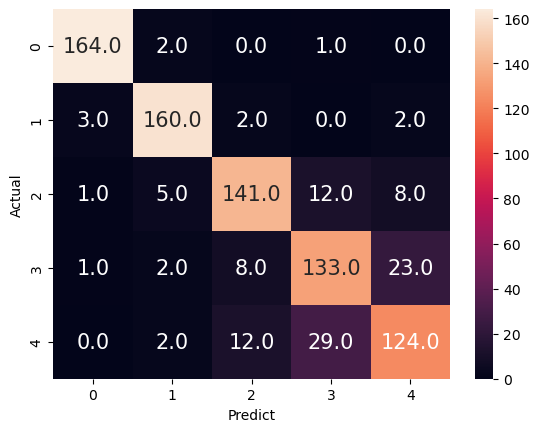

In [127]:
test_loss, test_acc = model.evaluate(x_test_pre_res,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre_res),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# ResNet50 with trainable layers

In [128]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers[:143]:
    layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(i,layer.name,"-",layer.trainable)

0 input_16 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv -

In [129]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "ResNet50_with_trainable_layers")
model.summary()

Model: "ResNet50_with_trainable_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_25 (Flatten)        (None, 51200)             0         
                                                                 
 dense_75 (Dense)            (None, 64)                3276864   
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dense_77 (Dense)            (None, 5)                 165       
                                                                 
Total params: 26,866,821
Trainable params: 18,255,109
Non-trainable params: 8,611,712
_________________________________________________________________


In [130]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre_res, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre_res,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 86s 811ms/step - loss: 1.6569 - accuracy: 0.7980 - val_loss: 54.2263 - val_accuracy: 0.5066
Epoch 2/33
102/102 [==============================] - 83s 816ms/step - loss: 0.8803 - accuracy: 0.8901 - val_loss: 1.9457 - val_accuracy: 0.8371
Epoch 3/33
102/102 [==============================] - 82s 807ms/step - loss: 0.4166 - accuracy: 0.9465 - val_loss: 0.4252 - val_accuracy: 0.8922
Epoch 4/33
102/102 [==============================] - 80s 789ms/step - loss: 0.2342 - accuracy: 0.9734 - val_loss: 0.4210 - val_accuracy: 0.8790
Epoch 5/33
102/102 [==============================] - 76s 749ms/step - loss: 0.1721 - accuracy: 0.9812 - val_loss: 0.4371 - val_accuracy: 0.8898
Epoch 6/33
102/102 [==============================] - 81s 797ms/step - loss: 0.0749 - accuracy: 0.9937 - val_loss: 0.5633 - val_accuracy: 0.8647
Epoch 7/33
102/102 [==============================] - 78s 764ms/step - loss: 0.0713 - accuracy: 0.9949 - val_loss: 0.5105 - val_a

27/27 - 12s - loss: 0.5106 - accuracy: 0.8970 - 12s/epoch - 455ms/step
27/27 [==============================] - 13s 456ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       167
           1       0.98      0.96      0.97       167
           2       0.90      0.89      0.89       167
           3       0.80      0.86      0.83       167
           4       0.83      0.77      0.80       167

    accuracy                           0.90       835
   macro avg       0.90      0.90      0.90       835
weighted avg       0.90      0.90      0.90       835



Text(50.722222222222214, 0.5, 'Actual')

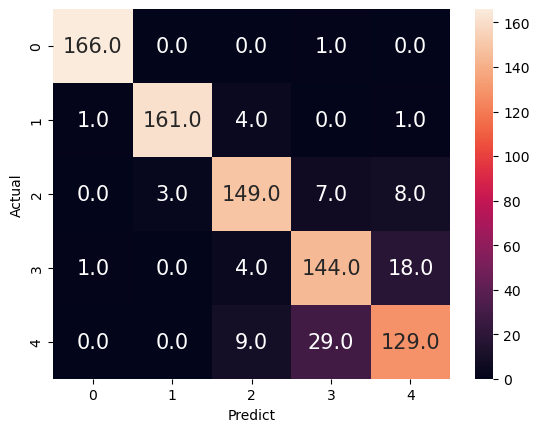

In [131]:
test_loss, test_acc = model.evaluate(x_test_pre_res,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre_res),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# ResNet50 with trainable layers and bigger weights

In [89]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers[:143]:
    layer.trainable = False

In [90]:
for i, layer in enumerate(base_model.layers):
    print(i,layer.name,"-",layer.trainable)

0 input_6 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [94]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "ResNet50_with_trainable_layers_and_bigger_weights")
model.summary()

Model: "ResNet50_with_trainable_layers_and_bigger_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_15 (Flatten)        (None, 51200)             0         
                                                                 
 dense_45 (Dense)            (None, 64)                3276864   
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 5)                 165       
                                                                 
Total params: 26,866,821
Trainable params: 18,255,109
Non-trainable params: 8,611,712
_______________________________________________________________

In [96]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3])*2,
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])*5}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre_res, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre_res,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 84s 792ms/step - loss: 4.0341 - accuracy: 0.6830 - val_loss: 43.9364 - val_accuracy: 0.6395
Epoch 2/33
102/102 [==============================] - 75s 739ms/step - loss: 1.6698 - accuracy: 0.8626 - val_loss: 49.8061 - val_accuracy: 0.6515
Epoch 3/33
102/102 [==============================] - 82s 808ms/step - loss: 0.8198 - accuracy: 0.9405 - val_loss: 0.4758 - val_accuracy: 0.8599
Epoch 4/33
102/102 [==============================] - 76s 747ms/step - loss: 0.4872 - accuracy: 0.9644 - val_loss: 0.4316 - val_accuracy: 0.8754
Epoch 5/33
102/102 [==============================] - 78s 765ms/step - loss: 0.2314 - accuracy: 0.9842 - val_loss: 0.6543 - val_accuracy: 0.8347
Epoch 6/33
102/102 [==============================] - 77s 752ms/step - loss: 0.1704 - accuracy: 0.9895 - val_loss: 0.4704 - val_accuracy: 0.8958
Epoch 7/33
102/102 [==============================] - 76s 744ms/step - loss: 0.0903 - accuracy: 0.9955 - val_loss: 0.4722 - val_

27/27 - 12s - loss: 0.4704 - accuracy: 0.8958 - 12s/epoch - 454ms/step
27/27 [==============================] - 12s 409ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       167
           1       0.96      0.96      0.96       167
           2       0.90      0.86      0.88       167
           3       0.85      0.81      0.83       167
           4       0.78      0.84      0.81       167

    accuracy                           0.90       835
   macro avg       0.90      0.90      0.90       835
weighted avg       0.90      0.90      0.90       835



Text(50.722222222222214, 0.5, 'Actual')

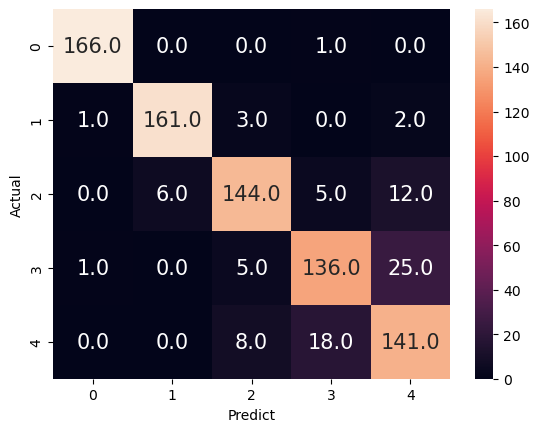

In [97]:
test_loss, test_acc = model.evaluate(x_test_pre_res,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre_res),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# ResNet101

In [132]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
## Preprocessing input do not scale the if you want to use this preprocess!!!!!!!!!
x_train_pre_res = preprocess_input(x_train) 
x_test_pre_res = preprocess_input(x_test)

In [133]:
base_model = ResNet101V2(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_17[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']   

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 38, 38, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 19, 19, 512)  0           ['conv3_block1_out[0][0]',       
          

 conv4_block1_1_conv (Conv2D)   (None, 10, 10, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 12, 12, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 10, 10, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 10, 10, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 12, 12, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 10, 10, 256)  589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv4_block8_out (Add)         (None, 10, 10, 1024  0           ['conv4_block7_out[0][0]',       
                                )                                 'conv4_block8_3_conv[0][0]']    
                                                                                                  
 conv4_block9_preact_bn (BatchN  (None, 10, 10, 1024  4096       ['conv4_block8_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block9_preact_relu (Acti  (None, 10, 10, 1024  0          ['conv4_block9_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_blo

 conv4_block11_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block11_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block11_2_pad[0][0]']    
                                                                                                  
 conv4_block11_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block11_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block11_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block14_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block14_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block14_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block16_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block16_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block16_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block16_out (Add)        (None, 10, 10, 1024  0           ['conv4_block15_out[0][0]',      
                                )                                 'conv4_block16_3_conv[0][0]']   
          

                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block19_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block21_out (Add)        (None, 10, 10, 1024  0           ['conv4_block20_out[0][0]',      
                                )                                 'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_block22_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block21_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block22_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block22_preact_bn[0][0]']
 ivation)                       )                                                                 
          

 conv5_block1_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_pad (ZeroPaddin  (None, 7, 7, 512)   0           ['conv5_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 5, 5, 512)    2359296     ['conv5_block1_2_pad[0][0]']     
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 post_bn (BatchNormalization)   (None, 5, 5, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 5, 5, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
Total params: 42,626,560
Trainable params: 0
Non-trainable params: 42,626,560
__________________________________________________________________________________________________


In [134]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "Simple_ResNet101")
model.summary()

Model: "Simple_ResNet101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 flatten_26 (Flatten)        (None, 51200)             0         
                                                                 
 dense_78 (Dense)            (None, 64)                3276864   
                                                                 
 dense_79 (Dense)            (None, 32)                2080      
                                                                 
 dense_80 (Dense)            (None, 5)                 165       
                                                                 
Total params: 45,905,669
Trainable params: 3,279,109
Non-trainable params: 42,626,560
_________________________________________________________________


In [135]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre_res, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre_res,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 104s 957ms/step - loss: 2.1255 - accuracy: 0.7377 - val_loss: 0.6969 - val_accuracy: 0.7150
Epoch 2/33
102/102 [==============================] - 95s 934ms/step - loss: 0.7554 - accuracy: 0.8871 - val_loss: 0.5502 - val_accuracy: 0.8359
Epoch 3/33
102/102 [==============================] - 96s 943ms/step - loss: 0.3514 - accuracy: 0.9576 - val_loss: 0.6097 - val_accuracy: 0.8216
Epoch 4/33
102/102 [==============================] - 97s 954ms/step - loss: 0.2033 - accuracy: 0.9734 - val_loss: 0.7377 - val_accuracy: 0.7940
Epoch 5/33
102/102 [==============================] - 97s 955ms/step - loss: 0.1594 - accuracy: 0.9818 - val_loss: 0.7288 - val_accuracy: 0.8096
Epoch 6/33
102/102 [==============================] - 96s 945ms/step - loss: 0.1660 - accuracy: 0.9818 - val_loss: 0.7643 - val_accuracy: 0.8036
Epoch 7/33
102/102 [==============================] - 97s 950ms/step - loss: 0.0968 - accuracy: 0.9913 - val_loss: 0.7196 - val_a

27/27 - 19s - loss: 0.6241 - accuracy: 0.8491 - 19s/epoch - 695ms/step
27/27 [==============================] - 20s 694ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       167
           1       0.95      0.91      0.93       167
           2       0.85      0.86      0.85       167
           3       0.71      0.85      0.77       167
           4       0.79      0.65      0.71       167

    accuracy                           0.85       835
   macro avg       0.85      0.85      0.85       835
weighted avg       0.85      0.85      0.85       835



Text(50.722222222222214, 0.5, 'Actual')

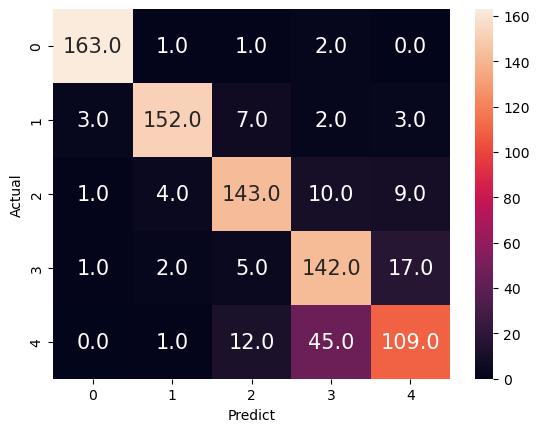

In [136]:
test_loss, test_acc = model.evaluate(x_test_pre_res,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre_res),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# ResNet101 with trainable layers

In [140]:
base_model = ResNet101V2(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
for layer in base_model.layers[:341]:
    layer.trainable = False
    
for i, layer in enumerate(base_model.layers):
    print(i,layer.name,"-",layer.trainable)

0 input_19 - False
1 conv1_pad - False
2 conv1_conv - False
3 pool1_pad - False
4 pool1_pool - False
5 conv2_block1_preact_bn - False
6 conv2_block1_preact_relu - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_pad - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_out - False
17 conv2_block2_preact_bn - False
18 conv2_block2_preact_relu - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_pad - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_out - False
28 conv2_block3_preact_bn - False
29 conv2_block3_preact_relu - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_pad - False


In [141]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
], name = "ResNet101_with_trainable_layers")
model.summary()

Model: "ResNet101_with_trainable_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 flatten_28 (Flatten)        (None, 51200)             0         
                                                                 
 dense_84 (Dense)            (None, 64)                3276864   
                                                                 
 dense_85 (Dense)            (None, 32)                2080      
                                                                 
 dense_86 (Dense)            (None, 5)                 165       
                                                                 
Total params: 45,905,669
Trainable params: 18,249,989
Non-trainable params: 27,655,680
_________________________________________________________________


In [142]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

weights = {0: 1.,
           1: len(y_train[y_train == 0])/len(y_train[y_train == 1]),
           2: len(y_train[y_train == 0])/len(y_train[y_train == 2]),
           3: len(y_train[y_train == 0])/len(y_train[y_train == 3]),
           4: len(y_train[y_train == 0])/len(y_train[y_train == 4])}

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

cp_path = "models_checkpoints/"+model.name+"/"+model.name
cp = ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filepath=cp_path)

history = model.fit(x_train_pre_res, y_train, epochs=33, batch_size=33,
                    validation_data = (x_test_pre_res,y_test),callbacks=[es,cp],class_weight=weights)

Epoch 1/33
102/102 [==============================] - 127s 1s/step - loss: 1.6264 - accuracy: 0.7610 - val_loss: 11.8266 - val_accuracy: 0.5281
Epoch 2/33
102/102 [==============================] - 118s 1s/step - loss: 0.7548 - accuracy: 0.9071 - val_loss: 0.5154 - val_accuracy: 0.8587
Epoch 3/33
102/102 [==============================] - 118s 1s/step - loss: 0.4960 - accuracy: 0.9411 - val_loss: 0.4239 - val_accuracy: 0.8671
Epoch 4/33
102/102 [==============================] - 118s 1s/step - loss: 0.3521 - accuracy: 0.9570 - val_loss: 0.8850 - val_accuracy: 0.8347
Epoch 5/33
102/102 [==============================] - 118s 1s/step - loss: 0.3080 - accuracy: 0.9627 - val_loss: 0.4800 - val_accuracy: 0.8551
Epoch 6/33
102/102 [==============================] - 118s 1s/step - loss: 0.2587 - accuracy: 0.9662 - val_loss: 0.5945 - val_accuracy: 0.8515
Epoch 7/33
102/102 [==============================] - 119s 1s/step - loss: 0.1845 - accuracy: 0.9815 - val_loss: 0.6053 - val_accuracy: 0.850

27/27 - 19s - loss: 0.6515 - accuracy: 0.8874 - 19s/epoch - 690ms/step
27/27 [==============================] - 20s 693ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       167
           1       0.99      0.97      0.98       167
           2       0.92      0.87      0.89       167
           3       0.77      0.81      0.79       167
           4       0.78      0.79      0.78       167

    accuracy                           0.89       835
   macro avg       0.89      0.89      0.89       835
weighted avg       0.89      0.89      0.89       835



Text(50.722222222222214, 0.5, 'Actual')

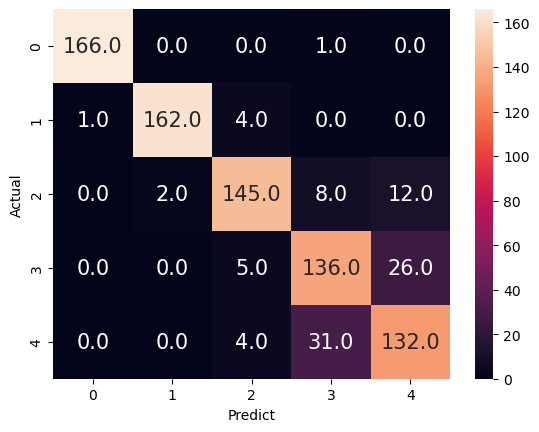

In [143]:
test_loss, test_acc = model.evaluate(x_test_pre_res,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test_pre_res),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# Ptolemy I VI XII  VS  9 

In [5]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == '0' : return 0
    elif word_label == '1' : return 0
    elif word_label == '6' : return 0
    elif word_label == '12' : return 0
    elif word_label == '9' : return 1

In [6]:
dir_n = r'mixed'
size = 150
is_gray = False
df = load_df(dir_n,size,is_gray)
class_num = 5
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

C:\Users\Liorka\AppData\Local\Temp\ipykernel_11852\1003655868.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(data.groupby('label').get_group(1).sample(n = samples_number))


In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 42)        12138     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 42)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 52)        19708     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 52)      

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=38,batch_size = 38)

Epoch 1/38
 84/102 [=======================>......] - ETA: 2s - loss: 0.9933 - accuracy: 0.8885

KeyboardInterrupt: 

11/11 - 3s - loss: 1.8887 - accuracy: 0.7725 - 3s/epoch - 250ms/step
11/11 [==============================] - 3s 215ms/step
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       167
           1       0.93      0.59      0.72       167

    accuracy                           0.77       334
   macro avg       0.82      0.77      0.76       334
weighted avg       0.82      0.77      0.76       334



Text(33.0, 0.5, 'Actual')

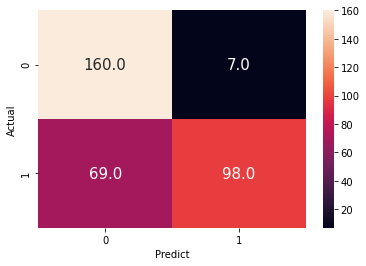

In [50]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# Ptolemy 12  VS  9 

In [103]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == '12' : return 0
    elif word_label == '9' : return 1

In [104]:
dir_n = r'9_12'
size = 150
is_gray = True
df = load_df(dir_n,size,is_gray)
class_num = 2
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

In [105]:
len(df)

1232

In [106]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 72, 72, 42)        12138     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 36, 36, 42)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 34, 34, 52)        19708     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 17, 17, 52)     

In [107]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=12,batch_size = 12,validation_data = (x_test,y_test))

Epoch 1/12
83/83 [==============================] - 31s 344ms/step - loss: 0.6832 - accuracy: 0.5832 - val_loss: 0.6973 - val_accuracy: 0.5000
Epoch 2/12
83/83 [==============================] - 27s 323ms/step - loss: 0.6806 - accuracy: 0.5994 - val_loss: 0.7152 - val_accuracy: 0.5000
Epoch 3/12
83/83 [==============================] - 27s 330ms/step - loss: 0.6752 - accuracy: 0.5994 - val_loss: 0.7002 - val_accuracy: 0.5000
Epoch 4/12
83/83 [==============================] - 27s 328ms/step - loss: 0.6751 - accuracy: 0.5994 - val_loss: 0.7046 - val_accuracy: 0.5000
Epoch 5/12
83/83 [==============================] - 27s 327ms/step - loss: 0.6555 - accuracy: 0.5994 - val_loss: 0.6473 - val_accuracy: 0.6382
Epoch 6/12
83/83 [==============================] - 27s 320ms/step - loss: 0.5585 - accuracy: 0.7181 - val_loss: 0.7068 - val_accuracy: 0.5081
Epoch 7/12
83/83 [==============================] - 27s 327ms/step - loss: 0.6692 - accuracy: 0.5913 - val_loss: 0.6916 - val_accuracy: 0.5041

8/8 - 2s - loss: 0.5418 - accuracy: 0.7358 - 2s/epoch - 189ms/step
8/8 [==============================] - 2s 186ms/step
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       123
           1       0.80      0.63      0.70       123

    accuracy                           0.74       246
   macro avg       0.75      0.74      0.73       246
weighted avg       0.75      0.74      0.73       246



Text(33.0, 0.5, 'Actual')

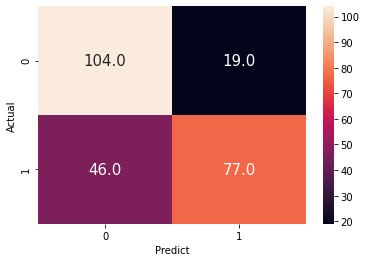

In [108]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(x_train, y_train,shuffle=True, epochs=8,batch_size = 12,validation_data = (x_test,y_test))

Epoch 1/8
83/83 [==============================] - 34s 393ms/step - loss: 0.3424 - accuracy: 0.8631 - val_loss: 0.4978 - val_accuracy: 0.7764
Epoch 2/8
83/83 [==============================] - 29s 343ms/step - loss: 0.3209 - accuracy: 0.8621 - val_loss: 0.5476 - val_accuracy: 0.7724
Epoch 3/8
83/83 [==============================] - 26s 318ms/step - loss: 0.2979 - accuracy: 0.8682 - val_loss: 0.5779 - val_accuracy: 0.7846
Epoch 4/8
83/83 [==============================] - 27s 320ms/step - loss: 0.2540 - accuracy: 0.8945 - val_loss: 0.5720 - val_accuracy: 0.7724
Epoch 5/8
83/83 [==============================] - 27s 327ms/step - loss: 0.2156 - accuracy: 0.8976 - val_loss: 0.5432 - val_accuracy: 0.7724
Epoch 6/8
83/83 [==============================] - 27s 327ms/step - loss: 0.1843 - accuracy: 0.9229 - val_loss: 0.5999 - val_accuracy: 0.7642
Epoch 7/8
83/83 [==============================] - 28s 332ms/step - loss: 0.1798 - accuracy: 0.9310 - val_loss: 0.5976 - val_accuracy: 0.7886
Epoch 

8/8 - 2s - loss: 0.6915 - accuracy: 0.7927 - 2s/epoch - 191ms/step
8/8 [==============================] - 2s 200ms/step
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       123
           1       0.76      0.85      0.80       123

    accuracy                           0.79       246
   macro avg       0.80      0.79      0.79       246
weighted avg       0.80      0.79      0.79       246



Text(33.0, 0.5, 'Actual')

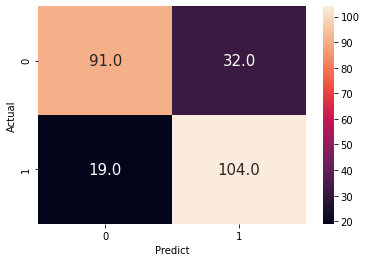

In [110]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

In [126]:
train_loss_values = np.concatenate((history.history['loss'], history2.history['loss']), axis=0)
test_loss_values = np.concatenate((history.history['val_loss'], history2.history['val_loss']), axis=0)
train_accuracy_values = np.concatenate((history.history['accuracy'], history2.history['accuracy']), axis=0)
test_accuracy_values = np.concatenate((history.history['val_accuracy'], history2.history['val_accuracy']), axis=0)

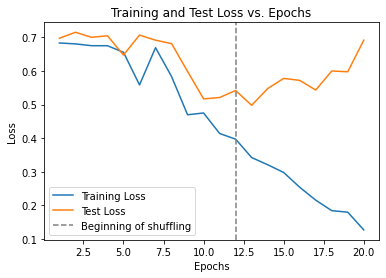

In [128]:
plt.plot(range(1, 20+1), train_loss_values, label='Training Loss')
plt.plot(range(1, 20+1), test_loss_values, label='Test Loss')
plt.axvline(x=12, color='gray', linestyle='--', label='Beginning of shuffling')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.legend()
plt.show()

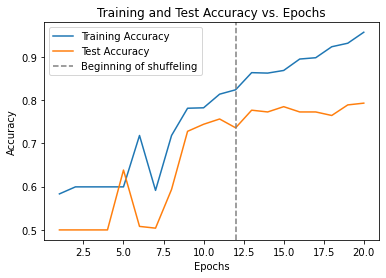

In [131]:
plt.plot(range(1, 20+1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, 20+1), test_accuracy_values, label='Test Accuracy')
plt.axvline(x=12, color='gray', linestyle='--', label='Beginning of shuffeling')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.legend()
plt.show()

## second try

In [136]:
def resnet_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, inputs])  # Residual connection
    return x

def build_resnet():
    inputs = tf.keras.Input(shape=(150, 150, 1))  # Grayscale image with size 150x150
    
    # 3 blocks with 2 layers of 16 filters
    x = layers.Conv2D(16, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(2):
        x = resnet_block(x, 16)
    
    # 3 blocks with 2 layers of 32 filters
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    for _ in range(3):
        x = resnet_block(x, 32)
    
    # 3 blocks with 2 layers of 64 filters
    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    for _ in range(3):
        x = resnet_block(x, 64)
    
    # Average pooling of 8x8
    x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(2, activation='softmax')(x)  # Add a classification layer
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the ResNet model
model = build_resnet()

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_112 (Conv2D)            (None, 150, 150, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 150, 150, 16  64         ['conv2d_112[0][0]']             
 ormalization)                  )                                                           

 conv2d_121 (Conv2D)            (None, 75, 75, 32)   9248        ['activation_41[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 75, 75, 32)  128         ['conv2d_121[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_42 (Activation)     (None, 75, 75, 32)   0           ['batch_normalization_42[0][0]'] 
                                                                                                  
 add_19 (Add)                   (None, 75, 75, 32)   0           ['activation_42[0][0]',          
                                                                  'add_18[0][0]']                 
                                                                                                  
 conv2d_12

 dense_52 (Dense)               (None, 2)            130         ['global_average_pooling2d_2[0][0
                                                                 ]']                              
                                                                                                  
Total params: 312,386
Trainable params: 311,074
Non-trainable params: 1,312
__________________________________________________________________________________________________


In [137]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=12,batch_size = 12,validation_data = (x_test,y_test))

Epoch 1/12


C:\Users\guyit\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 [==============================] - 273s 3s/step - loss: 0.8673 - accuracy: 0.5335 - val_loss: 0.7401 - val_accuracy: 0.5000
Epoch 2/12
83/83 [==============================] - 254s 3s/step - loss: 0.6887 - accuracy: 0.6034 - val_loss: 6.6880 - val_accuracy: 0.5000
Epoch 3/12
83/83 [==============================] - 247s 3s/step - loss: 0.6666 - accuracy: 0.6136 - val_loss: 0.9341 - val_accuracy: 0.5000
Epoch 4/12
83/83 [==============================] - 251s 3s/step - loss: 0.6203 - accuracy: 0.6521 - val_loss: 0.8286 - val_accuracy: 0.5000
Epoch 5/12
83/83 [==============================] - 256s 3s/step - loss: 0.6104 - accuracy: 0.6856 - val_loss: 0.7894 - val_accuracy: 0.5000
Epoch 6/12
83/83 [==============================] - 281s 3s/step - loss: 0.5628 - accuracy: 0.7191 - val_loss: 0.6685 - val_accuracy: 0.6748
Epoch 7/12
83/83 [==============================] - 264s 3s/step - loss: 0.5358 - accuracy: 0.7485 - val_loss: 0.6540 - val_accuracy: 0.6057
Epoch 8/12
83/83 [======

8/8 - 12s - loss: 0.5908 - accuracy: 0.6870 - 12s/epoch - 2s/step
8/8 [==============================] - 13s 1s/step
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       123
           1       0.76      0.54      0.64       123

    accuracy                           0.69       246
   macro avg       0.70      0.69      0.68       246
weighted avg       0.70      0.69      0.68       246



Text(33.0, 0.5, 'Actual')

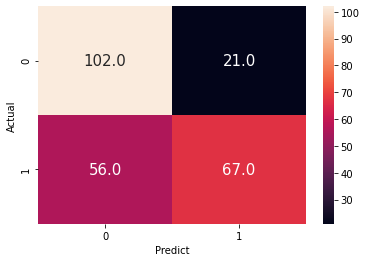

In [138]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

In [139]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(x_train, y_train,shuffle=True, epochs=8,batch_size = 12,validation_data = (x_test,y_test))

Epoch 1/8
83/83 [==============================] - 280s 3s/step - loss: 0.3456 - accuracy: 0.8540 - val_loss: 2.3799 - val_accuracy: 0.5041
Epoch 2/8
83/83 [==============================] - 301s 4s/step - loss: 0.2591 - accuracy: 0.8884 - val_loss: 3.0902 - val_accuracy: 0.5244
Epoch 3/8
83/83 [==============================] - 272s 3s/step - loss: 0.2201 - accuracy: 0.9189 - val_loss: 0.6170 - val_accuracy: 0.6829
Epoch 4/8
83/83 [==============================] - 269s 3s/step - loss: 0.1773 - accuracy: 0.9402 - val_loss: 1.2492 - val_accuracy: 0.6098
Epoch 5/8
83/83 [==============================] - 257s 3s/step - loss: 0.1648 - accuracy: 0.9432 - val_loss: 1.3527 - val_accuracy: 0.6504
Epoch 6/8
83/83 [==============================] - 258s 3s/step - loss: 0.1878 - accuracy: 0.9310 - val_loss: 1.2976 - val_accuracy: 0.6585
Epoch 7/8
83/83 [==============================] - 260s 3s/step - loss: 0.1262 - accuracy: 0.9635 - val_loss: 1.5096 - val_accuracy: 0.5081
Epoch 8/8
83/83 [===

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

In [ ]:
train_loss_values = np.concatenate((history.history['loss'], history2.history['loss']), axis=0)
test_loss_values = np.concatenate((history.history['val_loss'], history2.history['val_loss']), axis=0)
train_accuracy_values = np.concatenate((history.history['accuracy'], history2.history['accuracy']), axis=0)
test_accuracy_values = np.concatenate((history.history['val_accuracy'], history2.history['val_accuracy']), axis=0)

plt.plot(range(1, 20+1), train_loss_values, label='Training Loss')
plt.plot(range(1, 20+1), test_loss_values, label='Test Loss')
plt.axvline(x=12, color='gray', linestyle='--', label='Beginning of shuffling')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.legend()
plt.show()

plt.plot(range(1, 20+1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, 20+1), test_accuracy_values, label='Test Accuracy')
plt.axvline(x=12, color='gray', linestyle='--', label='Beginning of shuffeling')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.legend()
plt.show()

# VGG and ResNet

In [139]:
dir_n = r'mixed'
size = 224
is_gray = False
df = load_df(dir_n,size,is_gray)
class_num = 4
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

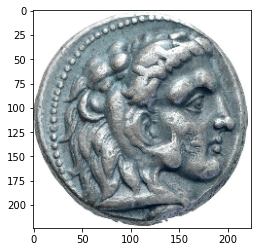

In [140]:
plt.imshow(x_train[0])

In [141]:
model = tf.keras.applications.resnet50.ResNet50(
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=4,
)
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

                                                                 conv4_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_bloc

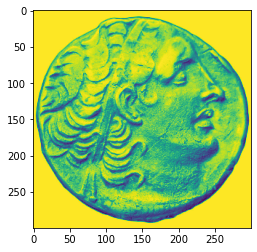

In [142]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10,batch_size = 10)

Epoch 1/10
  2/294 [..............................] - ETA: 2:33:43 - loss: 1.5167 - accuracy: 0.1500

KeyboardInterrupt: 

23/23 - 2s - loss: 0.5021 - accuracy: 0.9126
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       183
           1       0.98      0.92      0.95       183
           2       0.85      0.88      0.87       183
           3       0.88      0.86      0.87       183

    accuracy                           0.91       732
   macro avg       0.91      0.91      0.91       732
weighted avg       0.91      0.91      0.91       732



Text(33.0, 0.5, 'Actual')

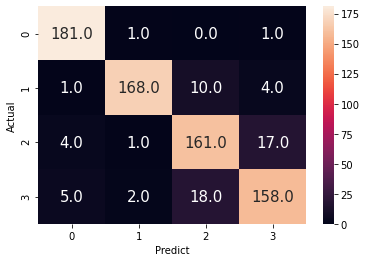

In [138]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")